<a href="https://colab.research.google.com/github/seohyeonlee2020/audio-converter/blob/img/poetics_and_protocols_of_sampling_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual "Sampling": Audio To Generative Art

Alex Lee
<br>Poetics and Protocols of Sampling Final Project

Project Architecture (In Progress)

 - get audio file
 - extract spectrogram
 - covert spectrogram to image
 - set device (cuda) and generative pipeline
 - feed spectrogram to pipeline
 - show image and save with timestamp

In [2]:
# --- Install dependencies ---
!pip install torch torchaudio torchvision diffusers transformers accelerate safetensors pillow matplotlib --quiet

In [21]:
# --- Imports ---
import io
import torch
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as vtrans
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline
import numpy as np

In [4]:
# --- Upload a .wav file ---
from google.colab import files
uploaded = files.upload()
audio_path = list(uploaded.keys())[0]

Saving Alex_sound_collage.wav to Alex_sound_collage.wav


In [22]:
import os
import torchaudio

# Check if the uploaded file is already a WAV
if not audio_path.lower().endswith('.wav'):
    print(f"Converting '{audio_path}' to WAV format...")
    # Load the audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    # Define a new WAV file path
    # Using os.path.splitext to get base name and then append .wav
    base_name = os.path.splitext(audio_path)[0]
    new_audio_path = f"{base_name}.wav"

    # Save as WAV
    torchaudio.save(new_audio_path, waveform, sample_rate)

    # Update audio_path to point to the new WAV file
    audio_path = new_audio_path
    print(f"Conversion complete. New audio path: '{audio_path}'")
else:
    print(f"File '{audio_path}' is already a WAV file. No conversion needed.")

File 'Alex_sound_collage.wav' is already a WAV file. No conversion needed.


Normalized Spectrogram


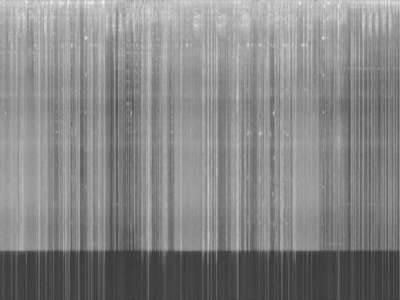

In [35]:
# --- Define helper functions ---
def get_spectrogram_image(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    spec = T.Spectrogram(n_fft=512)(waveform)
    if spec.shape[0] > 1:
        spec = spec.mean(dim=0, keepdim=True)
    spec_db = 10 * torch.log10(spec + 1e-9)
    spec_db = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min())
    spec_np = (spec_db.squeeze(0).numpy() * 255).astype(np.uint8)
    rgb_img = Image.fromarray(spec_np).convert("RGB")
    return rgb_img.resize((400, 300))

# --- Generate spectrogram image ---
spec_image = get_spectrogram_image(audio_path)

print("Normalized Spectrogram")
spec_image


In [36]:
# --- Setup device and model ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

✅ Saved as generative_art_from_Alex_sound_collage.wav_at_20251111_223050.png


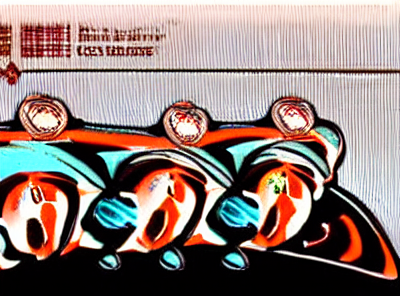

In [38]:
# --- Prompt and generation ---
prompt = (
   "caffeinated thoughts of a tired college student pulling their 2nd all nighter flying saucers and jellyfish living forever spicy pumpkin coffee abstract image no concrete objects"
)

#strength: between 0 and 1. represents how much the original image is changed.
#guidance_scale: how much influence the prompt has. works from 1 or higher. defaults to 7.5

result = pipe(
    prompt=prompt,
    negative_prompt="no letters, no people, no recognizable objects",
    image=spec_image,
    strength=0.9,
    guidance_scale=2.5,
).images

# --- Save and show result ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"generative_art_from_{audio_path}_at_{timestamp}.png"
result[0].save(filename)

print(f"✅ Saved as {filename}")
display(result[0])

